# Contents
............................................................................................................................................................................................................

2. [Introduction](#Introduction)
3. [The following are the important libraries](#The-following-are-the-important-libraries)
4. [Loading and Preprocessing Data for correct CSV file for validation](#Loading-and-Preprocessing-Data-for-correct-CSV-file-for-validation)
5. [Peak and Valley Detection with Data Segmentation](#Peak-and-Valley-Detection-with-Data-Segmentation)
6. [Data Filtering and Grouping](#Data-Filtering-and-Grouping)
7. [Loading and Preprocessing Data for CSV file for testing](#Loading-and-Preprocessing-Data-for-CSV-file-for-testing)
8. [Signal Data Visualization with Peaks and Valleys](#Signal-Data-Visualization-with-Peaks-and-Valleys)
9. [Shallow Feature Extraction Function](#Shallow-Feature-Extraction-Function)
10. [Feature Extraction and Data Concatenation](#Feature-Extraction-and-Data-Concatenation)
11. [Model Loading and Threshold Definitions](#Model-Loading-and-Threshold-Definitions)
12. [Anomaly Detection and Error Calculation](#Anomaly-Detection-and-Error-Calculation)
13. [Generating a List of Time Intervals for Faulty Data](#Generating-a-List-of-Time-Intervals-for-Faulty-Data)
14. [Plotting Comparison of Defective Data](#Plotting-Comparison-of-Defective-Data)
15. [Data Drift Detection and Threshold Analysis](#Data-Drift-Detection-and-Threshold-Analysis)


# Introduction
............................................................................................................................................................................................................

In this document, we present a comprehensive description of the columns in our dataset. These columns represent various aspects of a system's behavior and control. Understanding these columns is essential for the proper analysis and interpretation of the data. Below is a list of the column names and their corresponding descriptions:

1. **Time[us]**: Relative timestamp representing time in microseconds.

2. **PosDiff**: Difference between position (in a linear scale) and speed encoder.

3. **v act**: Actual value of the axis feed rate calculated from the position encoder.

4. **v act vctrl**: Shaft speed actual value calculated from the rotary speed encoder.

5. **s act**: Actual position.

6. **s nom**: Nominal position, which serves as the reference.

7. **a act**: Actual acceleration value calculated from the position encoder.

8. **M act**: Actual torque value.

9. **Iq nom**: Nominal current value, which determines torque.

10. **s diff**: Following error of the position controller.

These column descriptions will guide your analysis and help you better understand the data within this dataset.


# The following are the important libraries

............................................................................................................................................................................................................


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile 
import re
from scipy.stats import iqr, kurtosis, skew
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import numpy as np
from scipy.signal import find_peaks
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Loading and Preprocessing Data for correct CSV file for validation
............................................................................................................................................................................................................


In the code snippet provided, we perform the following operations:

1. **Column Indices Selection**: We define a list called `column_indices`, which specifies the indices of the columns to be selected from the CSV file.

2. **Column Name Mapping**: We specify the expected column names in the `expected_columns` list. These names will be assigned to the columns after loading the data.

3. **Initial Time Setting**: We set the `initial_time` to -464151000.0, which will be used as a filter condition on the 'Time' column.

4. **Data Loading**: We use the `pd.read_csv` function from the Pandas library to read a CSV file located at 'C:\Users\sandy\Thesis\ICNAP+Predictive+Maintenance\Ideal_df\2020-11-25_09-10-56-DTT-MILLP500U-X.csv'. We specify the delimiter as ";" and use the `usecols` parameter to select columns specified in `column_indices`.

5. **Column Renaming**: We rename the columns of the DataFrame `df_corr` to match the expected column names defined in `expected_columns`.

6. **Data Filtering**: We filter the rows of the DataFrame where the 'Time' column is greater than or equal to the `initial_time`. The result is stored in `df_corr` after resetting the index.

This code is designed to load and preprocess data from a CSV file, ensuring that the selected columns have meaningful names and only include data relevant to a specific time range.


In [4]:
column_indices = [0, 1, 2, 4, 6, 8, 9]
expected_columns = ['Time','PosDiff/X', 'v act/X', 's act/X','a act/X', 'I (nom)/X', 's diff/X']
initial_time = -464151000.0

df_corr = pd.read_csv(r'C:\Users\sandy\Thesis\ICNAP+Predictive+Maintenance\Ideal_df\2020-11-25_09-10-56-DTT-MILLP500U-X.csv',delimiter=";", usecols=column_indices)
df_corr.columns= expected_columns
df_corr = df_corr[df_corr['Time'] >= initial_time].reset_index(drop=True)

In [5]:
df_corr.head()

,Time,PosDiff/X,v act/X,s act/X,a act/X,I (nom)/X,s diff/X
0,-464151000.0,0.000027,-1006.152344,280.422062,-0.009766,-0.677413,-0.000059
1,-464148000.0,0.000028,-1005.761719,280.371774,0.002170,-0.416481,-0.000059
2,-464145000.0,-0.000022,-1006.835937,280.321432,-0.005968,-0.334461,0.000000
3,-464142000.0,-0.000064,-1006.640625,280.271100,0.001085,-0.589612,0.000063
4,-464139000.0,-0.000047,-1004.980469,280.220851,0.009223,-0.630627,0.000088


## Peak and Valley Detection with Data Segmentation
............................................................................................................................................................................................................


In this code snippet, we perform several data processing steps, including peak and valley detection, segmentation, and creating segmented dataframes. Here's a breakdown of the key operations:

1. **Peak Detection**: We use the `find_peaks` function to detect peaks in the third column of the `df_corr` DataFrame and store the indices of the detected peaks in the `peaks` variable.

2. **Valley Detection**: Similarly, we detect valleys by negating the signal data and storing the indices in the `valleys` variable.

3. **Filtering Peaks and Valleys**: We calculate the length of peaks and valleys that meet specific criteria based on data range and values.

4. **Warm-up Length**: We compute the `warm_len` as the sum of valid peaks and valleys lengths.

5. **Data Segmentation Parameters**: We determine the `start_point`, `end_point`, and `step_size` to define segments for further data processing.

6. **Segmented Data Preparation**: We create a list named `exp_corr` and populate it with segmented dataframes from the original `df_corr` based on the defined segments. The dataframes are indexed and stored in the list, and the segmentation is based on both valleys and peaks depending on the iteration.

This code is essential for segmenting the data into smaller chunks, which can be further analyzed or processed independently. It makes use of peak and valley detection to define these segments and collect the data within them.


In [6]:
peaks, _ = find_peaks(df_corr.iloc[:,3])
#peaks_idx.append(peaks)
valleys, _ = find_peaks(-df_corr.iloc[:,3])  # Find valleys by negating the signal data
#valleys_idx.append(valleys)

a= len(df_corr.iloc[:,3][valleys][(df_corr.iloc[:,3][valleys] > 50) & (df_corr.iloc[:,3][valleys] < 600) & (df_corr.iloc[:,3][valleys].index<20000)].index)
b= len(df_corr.iloc[:,3][peaks][(df_corr.iloc[:,3][peaks] > 500) & (df_corr.iloc[:,3][peaks] < 600) & (df_corr.iloc[:,3][peaks].index>20000) & (df_corr.iloc[:,3][peaks].index<80000)].index) 

warm_len= a + b

start_point = warm_len
end_point = peaks.shape[0]

# Calculate the step size based on the number of steps (3 in this case)
step_size = 3
# Create the array with multiples of 3 till 15 times
req_segment= np.arange(warm_len, end_point,step_size)


exp_corr = []

for j in range(0,5):
    exp_corr.append(pd.DataFrame(df_corr[valleys[req_segment[j]]: valleys[req_segment[j+1]]]).reset_index(drop= True))
for j in range(5,10):
    exp_corr.append(pd.DataFrame(df_corr[valleys[req_segment[j]]: valleys[req_segment[j+1]]]).reset_index(drop=True))
for j  in range(10,15):
    exp_corr.append(pd.DataFrame(df_corr[peaks[req_segment[j]]: peaks[req_segment[j+1]]]).reset_index(drop=True))

## Data Filtering and Grouping
............................................................................................................................................................................................................


In this code snippet, we perform data filtering and grouping operations, resulting in the creation of three lists: `exp_corr_1`, `exp_corr_2`, and `exp_corr_3`. These lists contain filtered and grouped dataframes based on specific conditions. Here's a breakdown of the operations:

1. **Data Filtering - `exp_corr1_X`**: We filter data in each of the `exp_corr` dataframes (from the previous code snippet) based on specific conditions for the third column. Each filtered dataframe is assigned to `exp_corr1_X`, where `X` represents the index of the corresponding dataframe.

2. **Grouping - `exp_corr_1`**: We create a list `exp_corr_1` that contains the filtered dataframes `exp_corr1_X`. These dataframes meet the respective filtering conditions.

3. **Grouping - `exp_corr_2` and `exp_corr_3`**: We iterate through the remaining `exp_corr` dataframes and separate them into `exp_corr_2` and `exp_corr_3` based on their indices.

4. **Final Grouping - `experiments_corr`**: We create a list `experiments_corr` containing `exp_corr_1`, `exp_corr_2`, and `exp_corr_3`. These lists group the segmented dataframes for further analysis.

This code prepares and organizes the segmented data for future analysis or processing, allowing you to work with subsets of the data based on specific conditions and groupings.


In [7]:
exp_corr1_1= (exp_corr[0][exp_corr[0].iloc[:,3]> 332].reset_index(drop= True))
exp_corr1_2= (exp_corr[1][exp_corr[1].iloc[:,3]>323])
exp_corr1_3= (exp_corr[2][exp_corr[2].iloc[:,3]>310])
exp_corr1_4= (exp_corr[3])
exp_corr1_5= (exp_corr[4][exp_corr[4].iloc[:,3]>250])

exp_corr_1 = [exp_corr1_1, exp_corr1_2, exp_corr1_3, exp_corr1_4, exp_corr1_5] 

exp_corr_2= []
exp_corr_3= []

for i in range(5,15):
    if i < 10:
        exp_corr_2.append(exp_corr[i])
    else :
        exp_corr_3.append(exp_corr[i])

experiments_corr= [exp_corr_1,exp_corr_2,exp_corr_3]

## Loading and Preprocessing Data for CSV file for testing
............................................................................................................................................................................................................

These are same as above provided description


In [8]:
#1. Define the columns that are useful after finding the correlation between all
#2. read the incoming dataframe
#3. Correct the columns name

column_indices = [0, 1, 2, 4, 6, 8, 9]
expected_columns = ['Time','PosDiff/X', 'v act/X', 's act/X','a act/X', 'I (nom)/X', 's diff/X']
initial_time = -464151000.0

Data= r"C:\Users\sandy\Thesis\2018-12-07_09-40-17-DTT-MillP500U-0009-X.csv"

df_x = pd.read_csv(Data,delimiter=";", usecols=column_indices)
df_x.columns= expected_columns
df_x = df_x[df_x['Time'] >= initial_time].reset_index(drop=True)

In [9]:
signal_data= df_x

peaks, _ = find_peaks(signal_data.iloc[:,3])
#peaks_idx.append(peaks)
valleys, _ = find_peaks(-signal_data.iloc[:,3])  # Find valleys by negating the signal data
#valleys_idx.append(valleys)

a= len(signal_data.iloc[:,3][valleys][(signal_data.iloc[:,3][valleys] > 50) & (signal_data.iloc[:,3][valleys] < 600) & (signal_data.iloc[:,3][valleys].index<20000)].index)
b= len(signal_data.iloc[:,3][peaks][(signal_data.iloc[:,3][peaks] > 500) & (signal_data.iloc[:,3][peaks] < 600) & (signal_data.iloc[:,3][peaks].index>20000) & (signal_data.iloc[:,3][peaks].index<80000)].index) 

warm_len= a + b

start_point = warm_len
end_point = peaks.shape[0]

# Calculate the step size based on the number of steps (3 in this case)
step_size = 3
# Create the array with multiples of 3 till 15 times
req_segment= np.arange(warm_len, end_point,step_size)


exp = []

for j in range(0,5):
    exp.append(pd.DataFrame(signal_data[valleys[req_segment[j]]: valleys[req_segment[j+1]]]).reset_index(drop= True))
for j in range(5,10):
    exp.append(pd.DataFrame(signal_data[valleys[req_segment[j]]: valleys[req_segment[j+1]]]).reset_index(drop=True))
for j  in range(10,15):
    exp.append(pd.DataFrame(signal_data[peaks[req_segment[j]]: peaks[req_segment[j+1]]]).reset_index(drop=True))

In [10]:
exp1_1= (exp[0][exp[0].iloc[:,3]> 332].reset_index(drop= True))
exp1_2= (exp[1][exp[1].iloc[:,3]>323])
exp1_3= (exp[2][exp[2].iloc[:,3]>310])
exp1_4= (exp[3])
exp1_5= (exp[4][exp[4].iloc[:,3]>250])

exp_1 = [exp1_1, exp1_2, exp1_3, exp1_4, exp1_5] 

exp_2= []
exp_3= []

for i in range(5,15):
    if i < 10:
        exp_2.append(exp[i])
    else :
        exp_3.append(exp[i])

experiments= [exp_1,exp_2,exp_3]

## Signal Data Visualization with Peaks and Valleys

............................................................................................................................................................................................................


In this code snippet, we visualize the signal data with lines separating segments, and we highlight peaks (in red) and valleys (in blue). The code performs the following tasks:

1. **Figure Creation**: We create a figure with a size of 20x10 to prepare for plotting the signal data.

2. **Plotting the Original Signal**: We plot the original signal data, which is stored in the DataFrame `signal_data` and is taken from the third column. The `label` parameter specifies the legend label for this line.

3. **Plotting Peaks and Valleys**: Peaks are marked in red ('r.') and valleys in blue ('b.'). We use the `peaks` and `valleys` indices calculated earlier to identify these points in the signal.

4. **Legend and Labels**: We add a legend to the plot to distinguish the original signal from the peaks and valleys. We also provide labels for the x-axis and y-axis and set the plot title.

5. **Grid Lines**: Grid lines are added to the plot to aid in visual reference.

6. **Display Plot**: Finally, we use `plt.show()` to display the plot.

This code snippet allows you to visualize the signal data, identify peaks and valleys, and clearly see the segments in the data, helping you better understand the behavior of the signal.


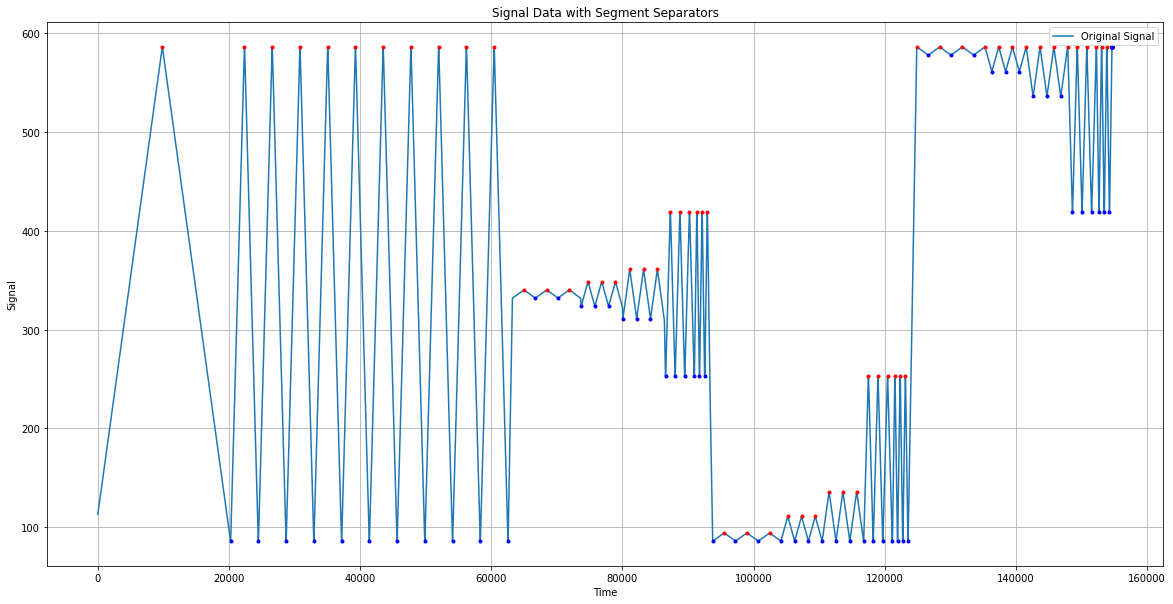

In [11]:
# Plot the signal data with lines separating the segments
i=3
plt.figure(figsize=(20, 10))
plt.plot(signal_data.iloc[:,i], label='Original Signal')

# Plot peaks (red) and valleys (blue)
plt.plot(signal_data.iloc[:,i].index[peaks],signal_data.iloc[:,i][peaks], 'r.')
plt.plot(signal_data.iloc[:,i].index[valleys],signal_data.iloc[:,i][valleys], 'b.')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Signal Data with Segment Separators')
plt.grid(True)
#plt.show()
#plt.savefig("pos")

## Shallow Feature Extraction Function

............................................................................................................................................................................................................

This Python function, named `fun_shallow_feature`, is designed for extracting a set of basic statistical features from a given input signal `x`. These features provide insights into the characteristics of the signal. Here's an explanation of the features and their calculations within the function:

- **Interquartile Range (iqr_val)**: It is computed as the difference between the third quartile (75th percentile) and the first quartile (25th percentile) of the input signal.

- **Kurtosis (kurt)**: Kurtosis measures the "tailedness" of the signal's probability distribution. It quantifies how much the data deviates from a normal distribution. A high kurtosis value indicates heavy tails.

- **Skewness (skewness)**: Skewness measures the asymmetry of the signal's distribution. Positive skewness indicates a long tail on the right, while negative skewness indicates a long tail on the left.

- **Root Mean Square (rms)**: RMS is a measure of the signal's energy. It is computed as the square root of the mean of the squared values of the signal.

- **Variance (variance)**: Variance measures the spread or dispersion of the signal. It is the average of the squared differences from the Mean.

- **Mean (mean_val)**: This is the arithmetic average of the input signal.

- **Maximum (max_val)**: It represents the highest value in the signal.

- **Minimum (min_val)**: It represents the lowest value in the signal.

- **Standard Deviation (std_dev)**: Standard deviation quantifies the amount of variation or dispersion in the signal.

- **Median (median_val)**: The median is the middle value of the signal when it is sorted. It is less sensitive to outliers than the mean.

- **Sum (summ)**: The sum of all values in the signal, scaled by a factor of 10,000.

The function returns a list of these computed features. In case of missing or non-numeric values in the input signal, the function replaces them with zeros using `np.nan_to_num`.

This function is useful for quickly obtaining fundamental statistics that can help characterize a given signal.


In [12]:
def fun_shallow_feature(x):
    # Raw signal features
    iqr_val = iqr(x)  # Interquartile Range
    kurt = kurtosis(x)  # Kurtosis
    skewness = skew(x)  # Skewness
    rms = sqrt(np.mean(np.square(x)))  # Root Mean Square
    variance = np.var(x)  # Variance
    mean_val = np.mean(x)  # Mean
    max_val = np.max(x)  # Maximum
    min_val = np.min(x)  # Minimum
    std_dev = np.std(x)  # Standard Deviation
    median_val = np.median(x)# Median
    summ= sum(x)/(10e+3)

    features = [iqr_val, kurt, skewness, rms, variance, mean_val, max_val, min_val, std_dev, median_val, summ]
    features = np.nan_to_num(features, nan=0, posinf=0, neginf=0)
    
    return features

## Feature Extraction and Data Concatenation

............................................................................................................................................................................................................

In this code snippet, we perform feature extraction and data concatenation to create a final DataFrame. The code is organized into nested loops for this purpose. Here's a breakdown of the key operations:

1. **Nested Loop Structure**: The code contains three nested loops, with each loop serving a specific purpose:
   - The outermost loop (`l`) iterates over three different experiments or data sets.
   - The middle loop (`i`) iterates over five different segments within each experiment.
   - The innermost loop (`j`) iterates just once (value 0) to handle each segment.

2. **Feature Extraction**: For each combination of `(l, i, j)`, a set of shallow features is extracted from the respective segment within the experiment. The `fun_shallow_feature` function is applied to each of the six columns (`k`) in the segment to obtain 66 features.

3. **Data Organization**: The extracted features are organized into a single list named `fea_i_single`. This list contains the features for a specific `(l, i, j)` combination.

4. **Data Concatenation**: The `fea_i_single` lists are concatenated along the rows to form the `df_final_exp` DataFrame, which contains the feature vectors for all combinations of `(l, i, j)`.

5. **Column Prefix Addition**: The columns of the `df_final_exp` DataFrame are given prefixes ('c') for clarity and to distinguish them from the original data columns.

The result is a final DataFrame, `df_final_exp`, that contains the extracted features for various segments within three different experiments. These features can be used for further analysis or modeling.


In [13]:
fea_i = []
for l in range(3):
    for i in range(5):
        for j in range(1):
            fea_i_single = []
            for k in range(6):
                fea_i_single.append(fun_shallow_feature(experiments[l][i].iloc[:,k+1])) 

            fea_i.append(pd.DataFrame(np.array(fea_i_single).reshape(1,66)))

df_final_exp = pd.concat(fea_i, axis=0, ignore_index=True)
df_final_exp = df_final_exp.add_prefix('c')

In [14]:
df_final_exp.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c56,c57,c58,c59,c60,c61,c62,c63,c64,c65
0,0.001918,-1.921917,0.004809,0.002941,9.348848e-07,0.002777,0.004080,0.001423,0.000967,0.002445,...,37.855555,-0.669267,0.000041,1.703618e-09,-8.484762e-08,0.000547,-0.000693,0.000041,0.000000,-8.642578e-08
1,0.001888,-1.234773,0.107067,0.002875,9.421393e-07,0.002706,0.007106,0.000147,0.000971,0.002777,...,28.111338,-0.356961,0.000078,6.033268e-09,-7.835463e-08,0.000874,-0.000967,0.000078,0.000000,-4.931641e-08
2,0.002004,-0.398144,0.040408,0.003043,1.521100e-06,0.002782,0.007446,-0.001511,0.001233,0.002809,...,13.437823,-0.078853,0.000107,1.148078e-08,1.751301e-07,0.001021,-0.001064,0.000107,0.000005,1.108398e-07
3,0.003856,0.849733,0.263849,0.004534,1.003387e-05,0.003243,0.014598,-0.006869,0.003168,0.003027,...,1.606464,-0.070454,0.000161,2.576548e-08,-2.755437e-07,0.000737,-0.000806,0.000161,0.000000,-1.206055e-07
4,0.005497,0.912709,0.284768,0.006141,2.315559e-05,0.003815,0.018116,-0.009215,0.004812,0.003477,...,0.803124,0.062567,0.000193,3.724186e-08,2.514330e-06,0.000786,-0.000791,0.000193,0.000005,5.976563e-07


# Model Loading and Threshold Definitions

............................................................................................................................................................................................................


In this code snippet, we load multiple machine learning models, define corresponding thresholds, and specify scaling methods for each model. The code organizes these components into lists. Here's a breakdown of the key operations:

1. **Model Loading**: We define a list of model names, `models`, which represent the filenames of pre-trained machine learning models. The code iterates through these model names and loads each model using `tf.keras.models.load_model()`. The loaded models are stored in the `loaded_model` list.

2. **Thresholds**: Three lists, `threshold`, `threshold_low`, and `threshold_high`, are defined to specify thresholds associated with the loaded models. Each threshold corresponds to a specific model and is used for making decisions or predictions.

3. **Scalers**: A list named `scales` is created to store the filenames of scaler objects used for preprocessing the data. These scalers are used to ensure data compatibility with the loaded models.

The code facilitates the application of multiple machine learning models to make predictions or decisions, with associated thresholds and data preprocessing steps. These components are organized for easy access and utilization.


In [15]:
models= ['my_model_exp1_1','my_model_exp1_2','my_model_exp1_3','my_model_exp1_4','my_model_exp1_5',
        'my_model_exp2_1','my_model_exp2_2','my_model_exp2_3','my_model_exp2_4','my_model_exp2_5',
        'my_model_exp3_1','my_model_exp3_2','my_model_exp3_3','my_model_exp3_4','my_model_exp3_5']
loaded_model =[] 
for model in models:
    loaded_model.append(tf.keras.models.load_model(model))   


threshold = [4.55, 2.6, 2.7, 1.4, 356665.36,
             0.81,1.38,1.1,0.97,202324.6,
             3358978000092.3,27797575.2,2307768.7,264120.5,369058.3]
threshold_low = [2.0, 1, 1,0.6,200000,0.3,0.6,0.4,0.4,100000,1e+12, 1e+7 , 1e+6, 1e+5,2e+5]
threshold_high = [3,2,2,1,300000,0.6,1,0.8,0.8,150000,2e+12,1.5e+7, 1.5e+6 , 1.5e+5, 3e+5]

scales = ['scaler1.pkl','scaler2.pkl','scaler3.pkl','scaler4.pkl','scaler5.pkl',
         'scaler2_1.pkl','scaler2_2.pkl','scaler2_3.pkl','scaler2_4.pkl','scaler2_5.pkl',
         'scaler3_1.pkl','scaler3_2.pkl','scaler3_3.pkl','scaler3_4.pkl','scaler3_5.pkl']

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Anomaly Detection and Error Calculation

............................................................................................................................................................................................................

In this code snippet, we perform anomaly detection and error calculation for a set of data instances. The code processes each data instance, scales it using a loaded scaler, makes predictions using the corresponding loaded model, calculates mean squared error (MSE), and classifies instances as outliers based on predefined thresholds. Here's a breakdown of the key operations:

1. **Empty DataFrame Creation**: We create an empty DataFrame named `Errors_df` with columns for 'Error_MSE' (Mean Squared Error) and 'Outlier_Status' to hold the results.

2. **Loop Over Data Instances**: The code iterates over the indices of the rows in the `df_final_exp` DataFrame to process each data instance.

3. **Data Scaling**: For each data instance, we load the corresponding scaler and apply it to preprocess the data for compatibility with the model. The scaled data is stored in `X_test`.

4. **Prediction and Error Calculation**: We use the loaded model to make predictions on the scaled data (`X_test`) and calculate the Mean Squared Error (`mse`) between the original data and the reconstructed data.

5. **Outlier Classification**: Based on the calculated MSE, we classify the instance as 'False' (not an outlier) if MSE is less than the lower threshold, 'Doubtful' if it falls within the range of the lower and upper thresholds, or 'True' (outlier) if it exceeds the upper threshold.

6. **DataFrame Creation and Appending**: For each data instance, we create a small DataFrame with 'Error_MSE' and 'Outlier_Status' columns, and then append it to the main `Errors_df`. This DataFrame accumulates results for all data instances.

The result is a DataFrame, `Errors_df`, that contains information about the mean squared errors and the outlier status of each data instance based on predefined thresholds. This information can be used for further analysis and decision-making.


In [16]:
# Create an empty DataFrame to hold the results
Errors_df = pd.DataFrame(columns=['Error_Mse', 'Outlier_Status'])

for i in df_final_exp.index:

    scaler= joblib.load(scales[i])
    X_test = df_final_exp.iloc[i:i+1, :].values
    X_test = scaler.transform(X_test)
    
    
    # Predict using the appropriate loaded model
    reconstructed_data= (loaded_model[i].predict(X_test))
    
    mse = np.mean((X_test - reconstructed_data) ** 2, axis=1)
    # Classify outliers based on the thresholds
    if mse < threshold_low[i]:
        outlier_status = 'False'
    elif threshold_low[i] <= mse <= threshold_high[i]:
        outlier_status = 'Doubtful'
    else:
        outlier_status = 'True'
    
    # Create a DataFrame for the current index and append to the main DataFrame
    error_df = pd.DataFrame({'Error_Mse': mse, 'Outlier_Status': outlier_status})
    Errors_df = pd.concat([Errors_df, error_df], ignore_index=True)

In [17]:
Errors_df.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Error_Mse,4.570926,2.609606,2.732514,1.411382,356665.363529,0.810842,1.382964,1.101081,1.156406,202335.773345,3358978000092.311523,27807332.097771,2309152.623715,264694.544677,440005.084675
Outlier_Status,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [50]:
defective_index= (Errors_df[Errors_df['Outlier_Status']=='True'].index+1)
all_index= np.array(Errors_df.index+1).tolist()
print(defective_index)
print(all_index)

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64')
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


## Generating a List of Time Intervals for Faulty Data

............................................................................................................................................................................................................

In this code snippet, we create a list, `faulty_dic`, to store time intervals for faulty data based on predefined criteria. The code processes indices of defective data instances and extracts the corresponding time intervals. Here's a breakdown of the key operations:

1. **List Initialization**: We initialize an empty list, `faulty_dic`, to hold dictionaries representing time intervals for faulty data.

2. **Loop Over Defective Indices**: The code iterates through a list of defective indices, represented by `defective_index`.

3. **Determination of Experiment and Segment**: The index is used to determine the experiment and segment (0 to 4) from which the faulty data originates.

4. **Time Interval Extraction**: For each defective index, we extract the time intervals from the original data stored in the `df_x` DataFrame. The specific time intervals are determined based on the experiment and segment, and they are stored in a dictionary format using `.to_dict()`.

5. **List Appending**: The extracted time intervals are appended to the `faulty_dic` list, creating a list of dictionaries, where each dictionary represents the time intervals for a specific instance of faulty data.

The result is a list, `faulty_dic`, that contains dictionaries with time intervals for faulty data. These time intervals can be used for further analysis or to isolate and investigate specific periods of data anomalies.


In [51]:
# faulty_dic = []
# for indx in defective_index:
#     if indx <= 4:
#         faulty_interval= []
#         faulty_interval.append(experiments[0][indx % 5].iloc[:, 0])
#         faulty_dic.append(df_x[df_x['Time'].isin(faulty_interval[0])].to_dict())
#     elif 5 <= indx <= 9:
#         faulty_interval= []
#         faulty_interval.append(experiments[1][indx % 5].iloc[:, 0])
#         faulty_dic.append(df_x[df_x['Time'].isin(faulty_interval[0])].to_dict())
#     else:
#         faulty_interval= []
#         faulty_interval.append(experiments[2][indx % 5].iloc[:, 0])
#         faulty_dic.append(df_x[df_x['Time'].isin(faulty_interval[0])].to_dict())


faulty_dic = []

for indx in defective_index:
    faulty_interval = []
    if indx <= 5:
        faulty_interval.extend(experiments[0][indx % 5].iloc[:, 0])
    elif 6 <= indx <= 10:
        faulty_interval.extend(experiments[1][indx % 5].iloc[:, 0])
    else:
        faulty_interval.extend(experiments[2][indx % 5].iloc[:, 0])

    filtered_data = df_x[df_x['Time'].isin(faulty_interval)]
    filtered_data.reset_index(drop=True, inplace=True)  # Reset index to start from 0
    faulty_dic.append(filtered_data.to_dict())


In [52]:
# all_signal_dic = []
# for indx in all_index:
#     if indx <= 4:
#         all_interval= []
#         all_interval.append(experiments[0][indx % 5].iloc[:, 0])
#         all_signal_dic.append(df_x[df_x['Time'].isin(all_interval[0])].to_dict())
#     elif 5 <= indx <= 9:
#         all_interval= []
#         all_interval.append(experiments[1][indx % 5].iloc[:, 0])
#         all_signal_dic.append(df_x[df_x['Time'].isin(all_interval[0])].to_dict())
#     else:
#         all_interval= []
#         all_interval.append(experiments[2][indx % 5].iloc[:, 0])
#         all_signal_dic.append(df_x[df_x['Time'].isin(all_interval[0])].to_dict())

all_signal_dic = []

for indx in all_index:
    all_interval = []
    if indx <= 4:
        all_interval.extend(experiments[0][indx % 5].iloc[:, 0])
    elif 5 <= indx <= 9:
        all_interval.extend(experiments[1][indx % 5].iloc[:, 0])
    else:
        all_interval.extend(experiments[2][indx % 5].iloc[:, 0])

    filtered_data = df_x[df_x['Time'].isin(all_interval)]
    filtered_data.reset_index(drop=True, inplace=True)  # Reset index to start from 0
    all_signal_dic.append(filtered_data.to_dict())



In [61]:
# corr_dic = []
# for indx in defective_index:
#     if indx <= 4:
#         corr_interval= []
#         corr_interval.append(experiments_corr[0][indx % 5].iloc[:, 0])
#         corr_dic.append(df_corr[df_corr['Time'].isin(corr_interval[0])].to_dict())
#     elif 5 <= indx <= 9:
#         corr_interval= []
#         corr_interval.append(experiments_corr[1][indx % 5].iloc[:, 0])
#         corr_dic.append(df_corr[df_corr['Time'].isin(corr_interval[0])].to_dict())
#     else:
#         corr_interval= []
#         corr_interval.append(experiments_corr[2][indx % 5].iloc[:, 0])
#         corr_dic.append(df_corr[df_corr['Time'].isin(corr_interval[0])].to_dict())

corr_dic = []

for indx in defective_index:
    corr_interval = []
    if indx <= 5:
        corr_interval.extend(experiments_corr[0][indx % 5].iloc[:, 0])
    elif 6 <= indx <= 10:
        corr_interval.extend(experiments_corr[1][indx % 5].iloc[:, 0])
    else:
        corr_interval.extend(experiments_corr[2][indx % 5].iloc[:, 0])

    filtered_data = df_corr[df_corr['Time'].isin(corr_interval)]
    filtered_data.reset_index(drop=True, inplace=True)  # Reset index to start from 0
    corr_dic.append(filtered_data.to_dict())



## Plotting Comparison of Defective Data

............................................................................................................................................................................................................


In this code snippet, we create a set of plots to compare defective data with corrected data. The code iterates through the columns (features) and plots the corresponding data for each defective index. Each subplot in the plot matrix shows the comparison of data between the original and corrected versions. Here's a breakdown of the key operations:

1. **Column Iteration**: The code iterates through columns, represented by `col`, ranging from 1 to 6.

2. **Plot Creation**: For each column, a new figure with a specified size is created to organize the subplots.

3. **Defective Data Comparison**: For each defective index (`indx`), we create a subplot and plot the defective data from the corresponding experiment (`experiments`) in the selected column.

4. **Corrected Data Comparison**: We also plot the corresponding corrected data from the experiment (`experiments_corr`) in the same column.

5. **Title and Labeling**: Each subplot is labeled with a title indicating the test and corrected experiments, such as "Test_Exp 1.1" and "Corr_Exp 1.1." The x-axis represents the index, and the y-axis is labeled with the column's name.

6. **Layout Adjustment**: We adjust the layout to ensure proper spacing and avoid overlap between subplots.

7. **Plot Display**: Finally, we display the entire set of plots using `plt.show()`.

The code enables the visual comparison of defective and corrected data for various columns, helping in the assessment of data correction effectiveness.


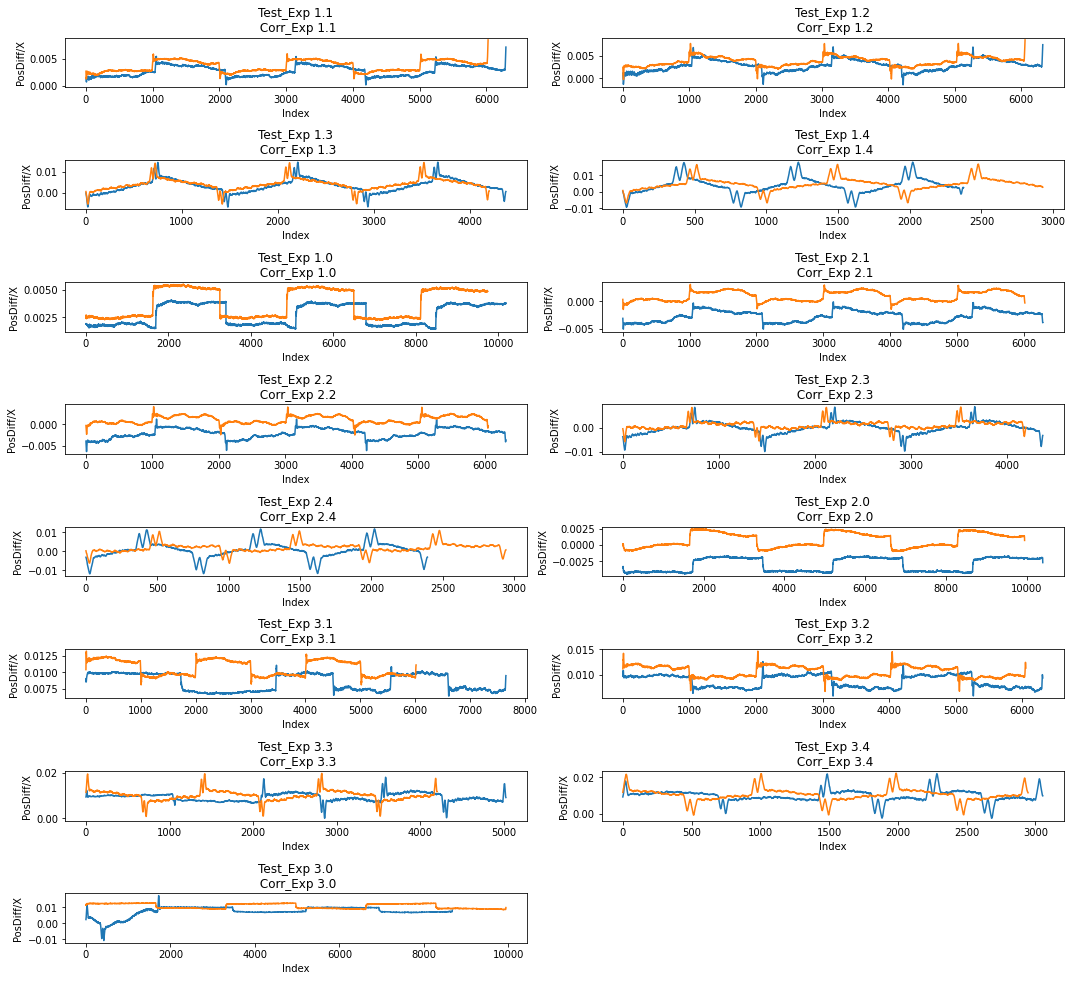

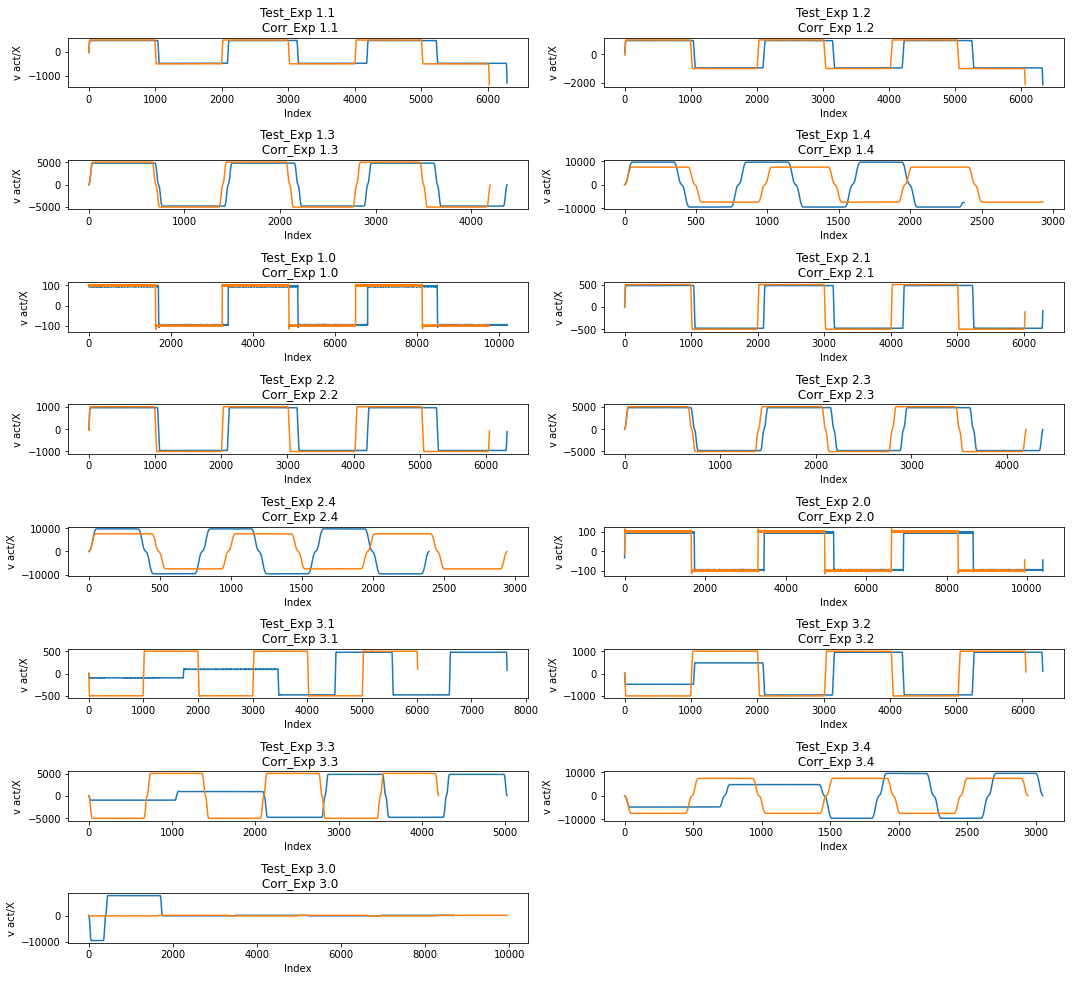

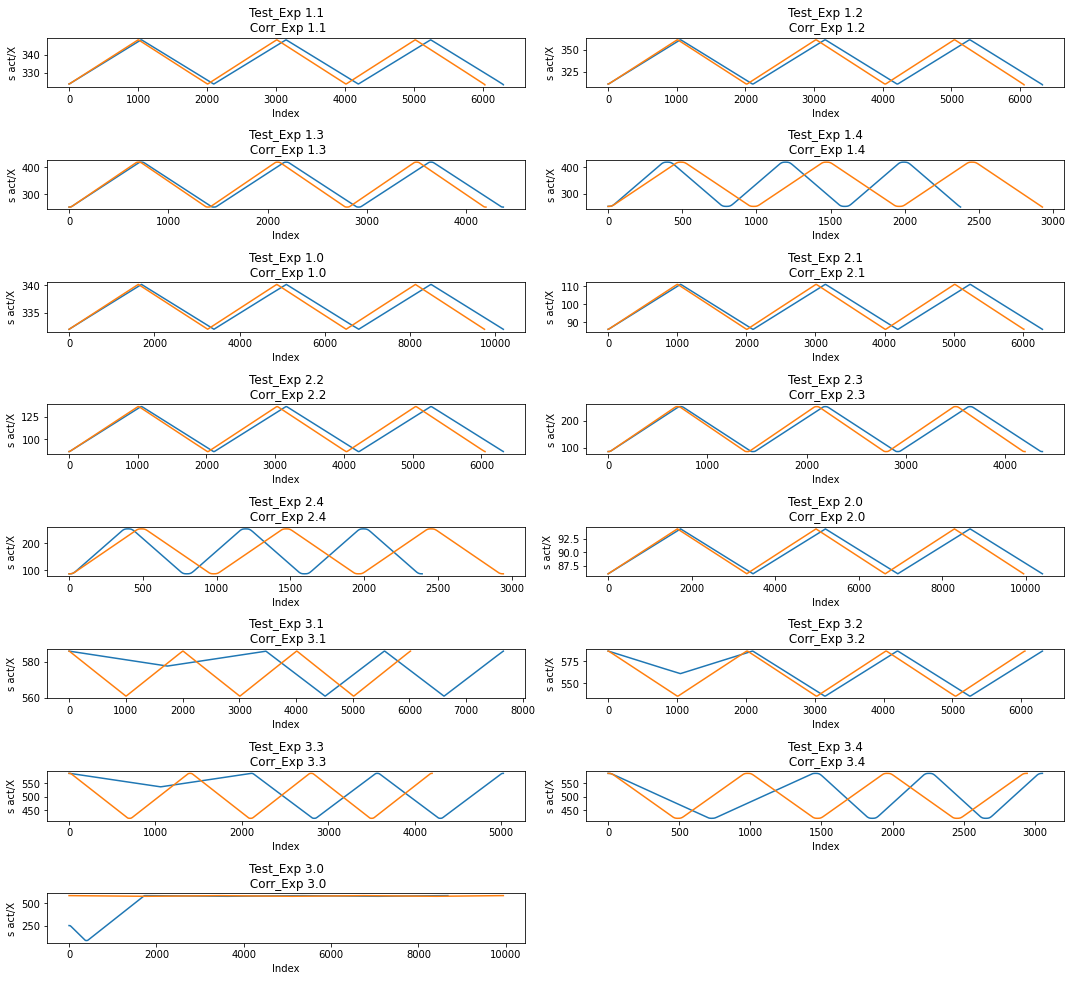

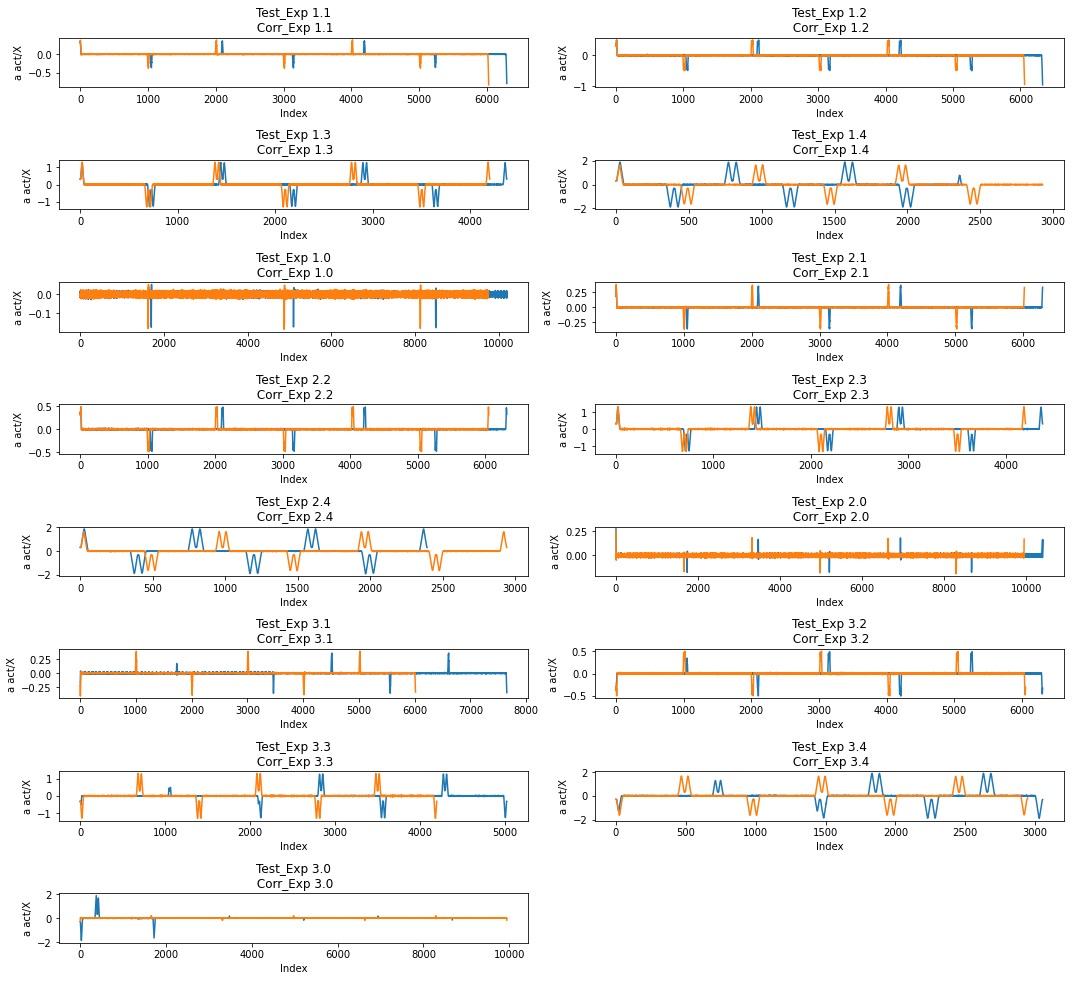

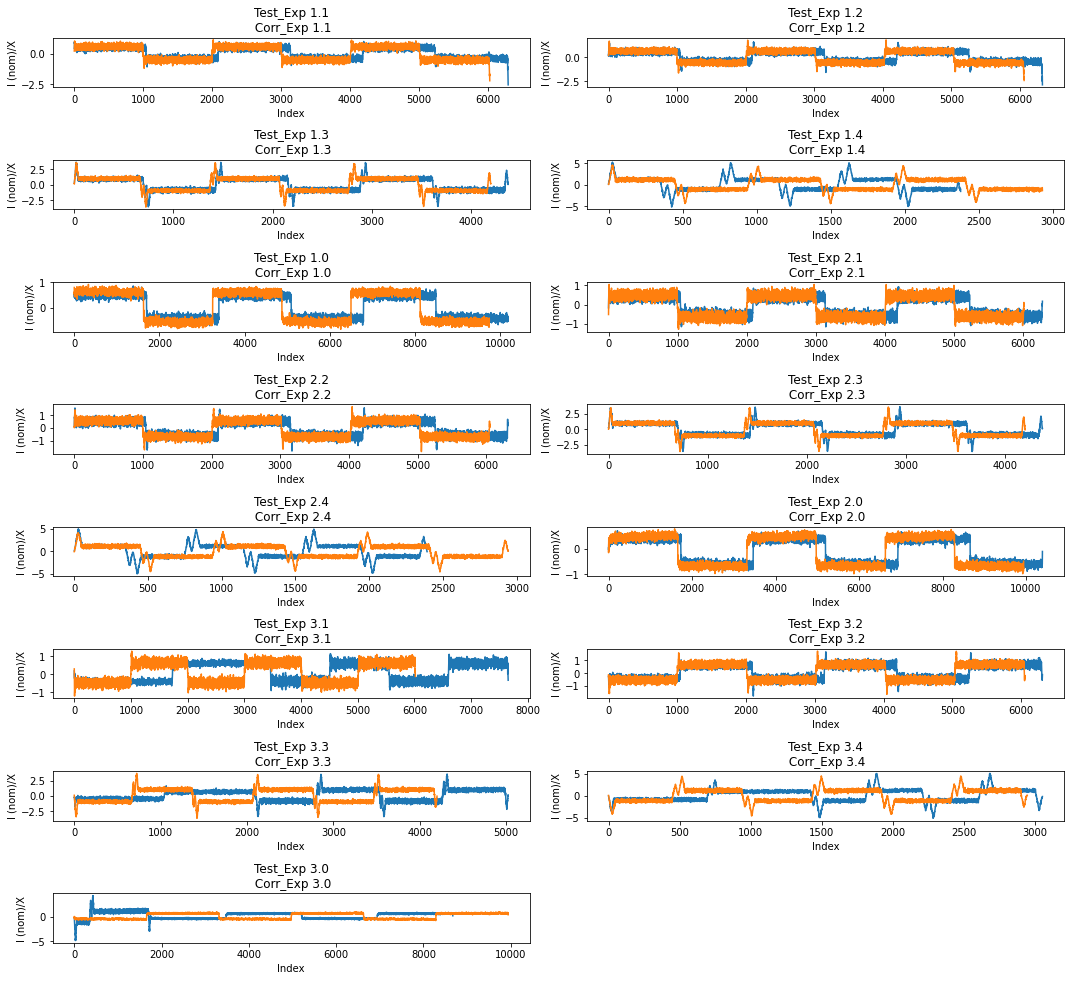

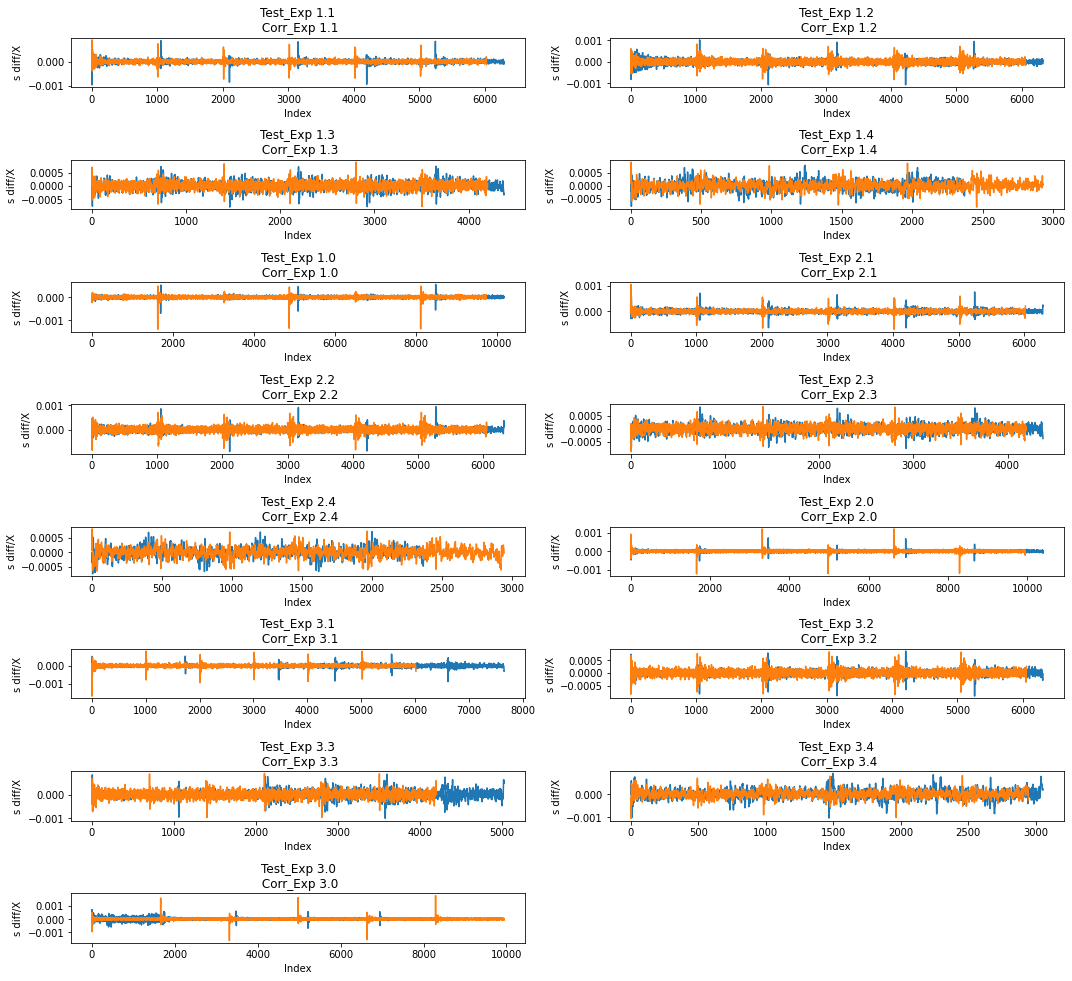

In [60]:
for col in range(1,7):
    plt.figure(figsize=(15,15))
    for i, indx in enumerate(all_index):
        plt.subplot(9,2,i+1)
        if indx<=4:
            plt.plot(experiments[0][indx%5].iloc[:, col])
            plt.plot(experiments_corr[0][indx%5].iloc[:, col])

            plt.title(f'''Test_Exp {1}.{indx%5+1}\n Corr_Exp {1}.{indx%5+1}''')
            

        elif 5<=indx<=9:
            plt.plot(experiments[1][indx%5].iloc[:, col])
            plt.plot(experiments_corr[1][indx%5].iloc[:, col])

            plt.title(f'''Test_Exp {2}.{indx%5+1}\n Corr_Exp {2}.{indx%5+1}''')
        else:
            plt.plot(experiments[2][indx%5].iloc[:, col])
            plt.plot(experiments_corr[2][indx%5].iloc[:, col])

            plt.title(f'''Test_Exp {3}.{indx%5+1}\n Corr_Exp {3}.{indx%5+1}''')

        plt.xlabel("Index")
        plt.ylabel(exp_1[1].columns[col])
        plt.tight_layout()
plt.show()

In [59]:
indx

15

# Data Drift Detection and Threshold Analysis

............................................................................................................................................................................................................


In this code snippet, we detect data drift and analyze the error with respect to a set of data drift thresholds. The code processes each data instance, scales it using a loaded scaler, makes predictions using the corresponding loaded model, calculates the Mean Squared Error (MSE), and classifies instances as exhibiting data drift or not based on predefined data drift thresholds. Here's a breakdown of the key operations:

1. **Threshold Initialization**: We define a list, `data_drift_threshold`, which specifies data drift thresholds for different columns. Each threshold corresponds to a specific column in the dataset.

2. **Empty DataFrame Creation**: We create an empty DataFrame, `Data_Drift_df`, with columns for 'Data_Drift_Threshold', 'Error_MSE', and 'Drift_Status' to hold the results.

3. **Loop Over Data Instances**: The code iterates over the indices of the rows in the `df_final_exp` DataFrame to process each data instance.

4. **Data Scaling**: For each data instance, we load the corresponding scaler and apply it to preprocess the data for compatibility with the model. The scaled data is stored in `X_test`.

5. **Prediction and Error Calculation**: We use the loaded model to make predictions on the scaled data (`X_test`) and calculate the Mean Squared Error (`mse`) between the original data and the reconstructed data.

6. **Data Drift Classification**: Based on the calculated MSE and predefined data drift thresholds, we classify the instance as 'False' (no drift) if the MSE is less than the threshold, or 'True' (drift) if it exceeds the threshold.

7. **DataFrame Creation and Appending**: For each data instance, we create a DataFrame with 'Data_Drift_Threshold', 'Error_MSE', and 'Drift_Status' columns. This DataFrame is appended to the main `Data_Drift_df`.

The result is a DataFrame, `Data_Drift_df`, that contains information about the data drift status of each data instance, along with the associated data drift thresholds and the calculated MSE. This information can be used for monitoring data drift and making decisions based on predefined thresholds.


In [21]:
data_drift_threshold = [5.2, 2.96, 3.54, 1.52, 538281, 
                        0.83, 1.46, 1.23, 1.16, 305532, 
                        4.27e+12, 2.79e+7, 2.32e+6, 2.65e+5, 4.41e+5]


Data_Drift_df = pd.DataFrame(columns=['Data_Drift_Threshold','Error_Mse', 'Drift_Status'])

for i in df_final_exp.index:

    scaler= joblib.load(scales[i])
    X_test = df_final_exp.iloc[i:i+1, :].values
    X_test = scaler.transform(X_test)
    
    
    # Predict using the appropriate loaded model
    reconstructed_data= (loaded_model[i].predict(X_test))
    
    mse = np.mean((X_test - reconstructed_data) ** 2, axis=1)
    # Classify outliers based on the thresholds
    if mse < data_drift_threshold[i]:
        data_drift = 'False'
    else:
        data_drift = 'True'
    
    # Create a DataFrame for the current index and append to the main DataFrame
    frame = pd.DataFrame({"Data_Drift_Threshold":data_drift_threshold[i],'Error_Mse': mse, 'Drift_Status': data_drift ,'Index': range(i,i+1)})
    Data_Drift_df = (pd.concat([Data_Drift_df, frame]))



In [22]:
Data_Drift_df.set_index('Index')

,Data_Drift_Threshold,Error_Mse,Drift_Status
Index,,,
0.0,5.200000e+00,4.570926e+00,False
1.0,2.960000e+00,2.609606e+00,False
2.0,3.540000e+00,2.732514e+00,False
3.0,1.520000e+00,1.411382e+00,False
4.0,5.382810e+05,3.566654e+05,False
5.0,8.300000e-01,8.108422e-01,False
6.0,1.460000e+00,1.382964e+00,False
7.0,1.230000e+00,1.101081e+00,False
8.0,1.160000e+00,1.156406e+00,False


-----------------------------------------------------------------**END** ----------------------------------------------------------------------------------------